In [6]:
import numpy as np
import json
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict
plt.rcParams['figure.figsize'] = [16, 56]
from plot_utils import *

In [7]:
def get_sp_score(smin,max_smin):
    return 1.0 - (smin/max_smin)

def plot_spuriousness_score(ax,epoch_num,run_list,pval_list,fname_pattern,sample_size,max_smin_acc):
    no_corr_pval = 0.5
    #Estimating the spuriousness score for each of the p-value
    sp_score_gold = []
    sp_score_ubound = []
    sp_score_lbound = []
    smin_list = []
    
    sp_score_stat_mean = []
    sp_score_stat_std = []
    for pval in pval_list:
        #Getting the gold-score
        actual_dict = get_all_result_dict(run_list=run_list,
                            pval_list=[pval,],
                            enum=epoch_num,
                            fname_pattern=fname_pattern.format(sample_size,"{}","{}")
        )
        sp_score_gold.append(get_sp_score(actual_dict[pval]["topic0_smin"]["mean"],max_smin_acc))
        smin_list.append(actual_dict[pval]["topic0_smin"]["mean"])
        
        #Getting the estimate of the sp-score
        estm_sample_size = int(np.round(2*(1-pval)*sample_size))
        estm_dict = get_all_result_dict(run_list=run_list,
                            pval_list=[no_corr_pval,],
                            enum=epoch_num,
                            fname_pattern=fname_pattern.format(estm_sample_size,"{}","{}")
        )
        sp_score_lbound.append(get_sp_score(actual_dict[pval]["topic0_smin"]["mean"],estm_dict[no_corr_pval]["topic0_smin"]["mean"]))
        sp_score_ubound.append(get_sp_score(actual_dict[pval]["topic0_smin"]["mean"],1))
        
        #Getting the estimate of sp-score using statistical estimate
        acc_smin_curr_p_list = actual_dict[pval]["topic0_smin"]["val_list"]
        acc_smin_max_est_list = estm_dict[no_corr_pval]["topic0_smin"]["val_list"]
        #Now getting the estimate of sp_score using all the different combination of both max and curr value
        sp_score_stat_estim_list = []
        for acc_smin_curr_run in acc_smin_curr_p_list:
            for acc_smin_max_run in acc_smin_max_est_list:
                sp_score_stat_estim_list.append(get_sp_score(acc_smin_curr_run,acc_smin_max_run))
        #Getting the stat points
        mean_sp_score_stat_estim = np.mean(sp_score_stat_estim_list)
        std_sp_score_stat_estim = np.std(sp_score_stat_estim_list)
        sp_score_stat_mean.append(mean_sp_score_stat_estim)
        sp_score_stat_std.append(std_sp_score_stat_estim)
        
    
    #Plotting the estimate
    if(type(ax)!=type(np.array([1,2]))):
        fig,ax = plt.subplots(2,)
    
    #Plotting the smin value
    ax[0].plot(pval_list,smin_list,marker="o",ls="-.")
    ax[0].set_ylabel("topi0_smin")
    ax[0].set_xlabel("correlation value [0.5-1.0]")
    ax[0].grid(True)
    
    #Plotting the sp-score
    yerr_ulim = [sp_score_ubound[xidx]-sp_score_gold[xidx] for xidx in range(len(pval_list))]
    yerr_llim = [sp_score_gold[xidx]-sp_score_lbound[xidx] for xidx in range(len(pval_list))]
    ax[1].errorbar(pval_list,sp_score_gold,yerr=(yerr_llim,yerr_ulim),marker="o",ls="-.",label="gold_score")
    ax[1].fill_between(pval_list, sp_score_lbound , sp_score_ubound,alpha=0.2)
    
    #Plotting the statistical estimate
    stat_ubound_line = [sp_score_stat_mean[pidx]+sp_score_stat_std[pidx] for pidx in range(len(pval_list))]
    stat_lbound_line = [sp_score_stat_mean[pidx]-sp_score_stat_std[pidx] for pidx in range(len(pval_list))]
    ax[1].errorbar(pval_list,sp_score_stat_mean,yerr=sp_score_stat_std,marker="o",ls="-.",label="stat_estimate")
    ax[1].fill_between(pval_list, stat_lbound_line , stat_ubound_line,alpha=0.2)
    
    ax[1].set_ylabel("spuriousness-score")
    ax[1].set_xlabel("correlation value [0.5-1.0]")
    ax[1].legend()
    ax[1].grid(True)
    
    return ax
    

        

# Getting the Acc(Smin)<sup>inf</sup><sub>p=0.5</sub>

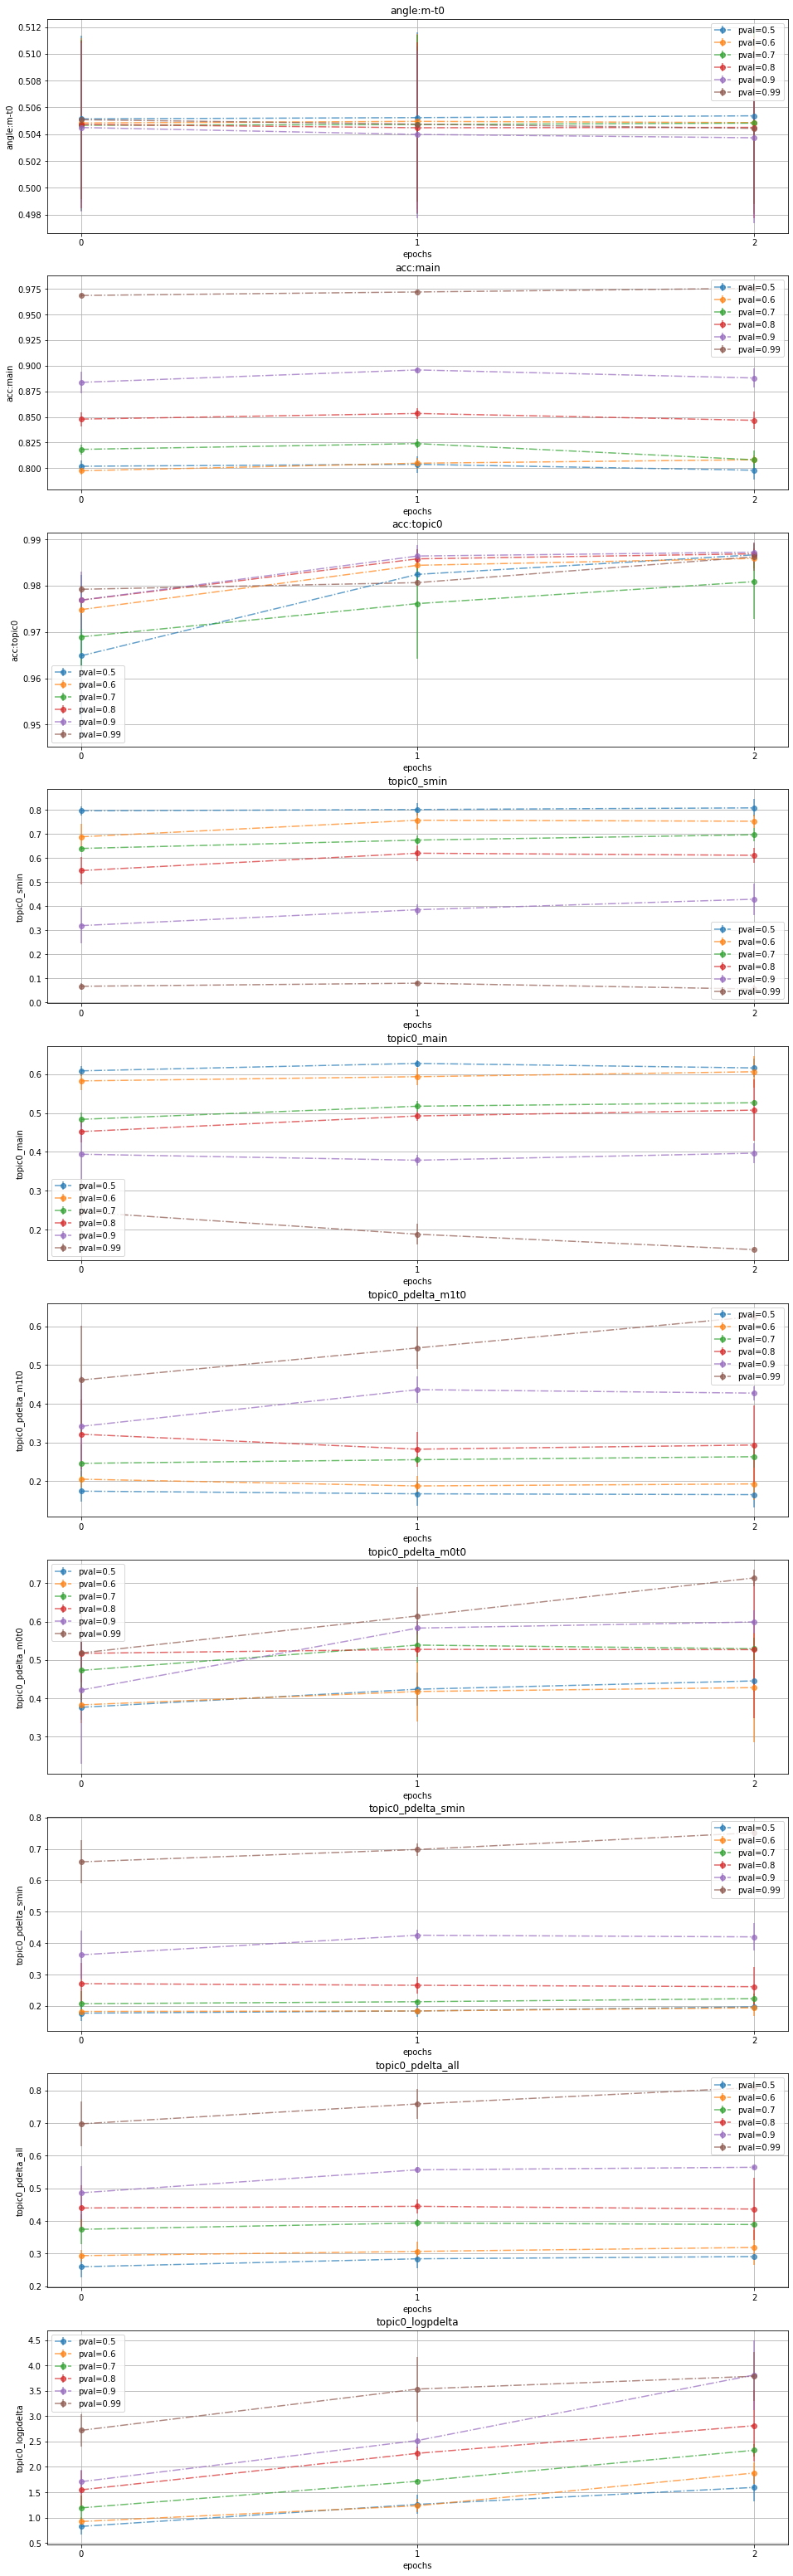

In [8]:
#Getting the best possbile Acc(Smin) estimate
run_list=[1,2,3]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
plot_item_list = [
                    "angle:m-t0",
                    "acc:main",
                    "acc:topic0",
                    "topic0_smin",
                    "topic0_main",
                    "topic0_pdelta_m1t0",
                    "topic0_pdelta_m0t0",
                    "topic0_pdelta_smin",
                    "topic0_pdelta_all",
                    "topic0_logpdelta",
]


ax=None

#Other hyperparam
model_type="bert-base-uncased"
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
d="non_causal"
n=0.0
h=0
e=3
s=35000
neg1_flip_method="remove_negation"
all_result_dict = get_all_result_timeline(run_list=run_list,
                                      pval_list=pval_list,
                                      fname_pattern="nlp_logs/pt.rel.model_type({}).neg1_fmethod({}).lt({}).dropout_rate({}).l2({}).noise({}).hlayer({}).sample({}).epoch({}).pval({}).rnum({})/probe_metric_list.json".format(
                                                                              model_type,
                                                                              neg1_flip_method,
                                                                              lt,
                                                                              drate,
                                                                              l2,
                                                                              n,
                                                                              h,
                                                                              s,
                                                                              e,
                                                                              "{}",
                                                                              "{}",
                                      )
)
plot_one_timeline(pval_list,all_result_dict,plot_item_list)

In [9]:
acc_smin_gold_estimate = all_result_dict[0.5]["topic0_smin"]["mean"][-1]
acc_smin_gold_std = all_result_dict[0.5]["topic0_smin"]["std"][-1]
print("Acc(Smin) gold accuracy estimate: {}".format(acc_smin_gold_estimate))
print("Acc(Smin) gold accuracy std: {}".format(acc_smin_gold_std))

Acc(Smin) gold accuracy estimate: 0.8083794116973877
Acc(Smin) gold accuracy std: 0.03688238009930482


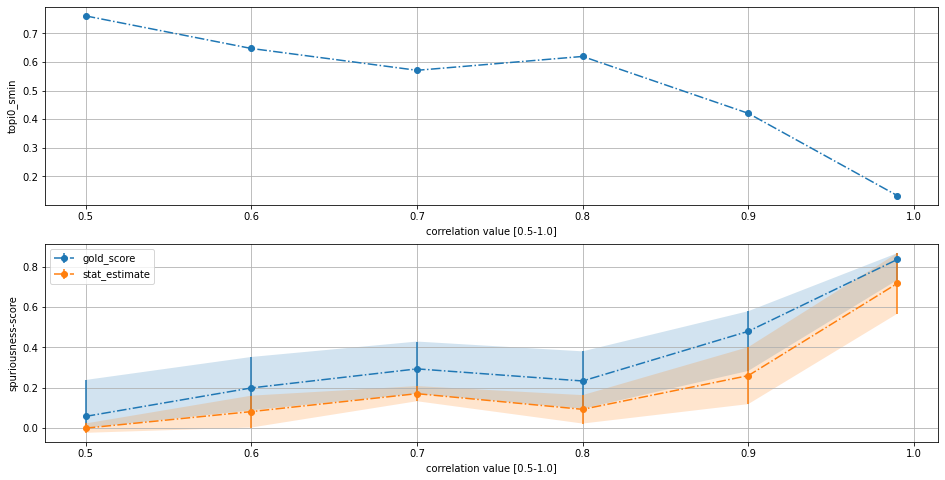

In [10]:
#Plotting the spuriousness score
plt.rcParams['figure.figsize'] = [16, 8]
run_list=[1,2,3]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
model_type="bert-base-uncased"
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
d="non_causal"
n=0.0
h=0
e=3
neg1_flip_method="remove_negation"
fname_pattern="nlp_logs/pt.rel.model_type({}).neg1_fmethod({}).lt({}).dropout_rate({}).l2({}).noise({}).hlayer({}).sample({}).epoch({}).pval({}).rnum({})/probe_metric_list.json".format(
                                  model_type,
                                  neg1_flip_method,
                                  lt,
                                  drate,
                                  l2,
                                  n,
                                  h,
                                  "{}",
                                  e,
                                  "{}",
                                  "{}",
)


#Plotting the score for N=10000
s=10000
ax=None
ax=plot_spuriousness_score(ax,e,run_list,pval_list,fname_pattern,s,acc_smin_gold_estimate)

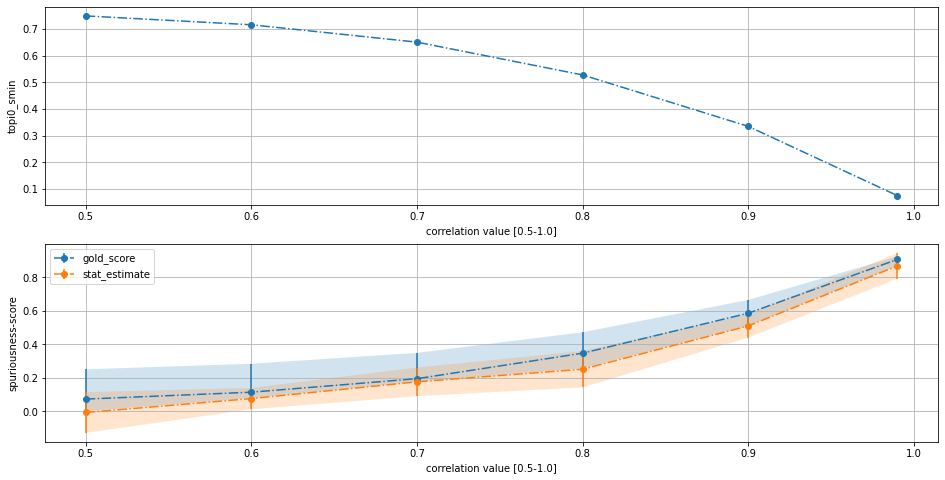

In [11]:
#Plotting the score for N=20000
s=20000
ax=None
ax=plot_spuriousness_score(ax,e,run_list,pval_list,fname_pattern,s,acc_smin_gold_estimate)